In [ ]:
from importlib import reload
import utils_functions
reload(utils_functions)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from utils_functions import *

# Part 1 Understanding and treating the data

## Part 1.1 Data conversion

The first step in our analysis is to ensure all data is represented consistently across the project. This involves converting the original **.txt** files containing ratings and reviews into **.csv** format. Each file was examined carefully, the strings were stored into dictionaries representing key data fields. More details on the conversion process and methodology can be found in **data/TxtToCsv.ipynb**

The CSV files can be found on the following link: https://drive.google.com/drive/folders/1lcRRxlPpcyAcqJzanlwcyb5Vmip0s7_D?usp=sharing
(You will need to ask for permission to see the files)

## Part 1.2 Data exploration

With the data now in a consistent format, we begin exploring deeper the datasets to understand their links and features. We learn especially that some breweries, beers, users matches between the websites. Moreover, their might be duplicates within the datasets, with some users having multiple accounts. Breweries also have duplicates: i.e a single brewery in ratebeer can correspond to up to 3 breweries in advocate. The goal of this notebook was also to look at the percentage of Nan values for the ratings, and to understand the different variables. Further explanations can be found in **data/data_understanding.ipynb**.

Furthermore an other Jupyter Notebook explores Nan values in the dataset. It is mainly a secondary file that was used to evaluate the percentage of Nan in columns of a dataframe. In there we look at the min/max value of the different grades, where we noticed that both datasets not necessarily contain the same range for their grades. More information can be found in **data/data_cleaning.ipynb**.

Some rows contain NaN values in the datasets. Since certain parts of the analysis do not require every feature, we handle missing data filtering based on the requirements of each analysis section.

## Part 1.3 Dataset merging
To enhance the robustness of the analysis, we merge data from both RateBeer and BeerAdvocate. This approach increases the number of ratings per beer enabling a higher reliability and enhancing the controversiality analysis.

The aim is to have a general dataset for users, beers, breweries and ratings. For users, breweries, ratings each one contains a new id, the old id from both datasets except for ratings. It also contains the name, location and other information. If it is match we often make a choice from which dataset to use the information, for example as two breweries in advocate are a single in ratebeer we decided to take the name of the brewery from ratebeer. We filter out the matched informations as a single one.

For ratings we have every rating of both datasets, even the one matched twice. We decided to keep them both as we noticed that comments may differ in the grading and textual description. We added columns corresponding to the new beer, user and brewery id. Certain attributes where deleted as we assumed that we could recompute them again, or if need could reload the old files. Finally we gave an id to each rating, the dataset of origin as 'rb' or 'ad', and we added a column called matched if filled with a number contains the id of the rating it is matched with.

Further information can be found add **data/merge_into_onedataset.ipynb**. The transformed data can be found at the following link:
https://drive.google.com/drive/folders/1McQ7BU24mEsEqouulOPqrmtQJ47E6ZP8?usp=sharing
(You will need to ask for permission).


**Data Loading**

For the whole the next cell calls the different datasets and is used for the rest of the notebook.

In [ ]:
root = Path(os.getcwd()).parent

#Change for each one of where your data is. For me in Dataset I have all the three folders
dataset_path = os.path.join(root,'Dataset')

FULL = "full"
FULL_PATH = os.path.join(dataset_path,FULL)

breweries_df = pd.read_csv(os.path.join(FULL_PATH, 'breweries.csv'))
beers_df = pd.read_csv(os.path.join(FULL_PATH, 'beers.csv'))
users_df = pd.read_csv(os.path.join(FULL_PATH, 'users.csv'))
ratings_df = pd.read_csv(os.path.join(FULL_PATH,'ratings.csv'))

**Grade transformation**

We noticed during the **data_cleaning.ipynb** that the grades are not based on the same range. We decided to set the grade between 1 and 5. If the attribute is between 1 and 20 and the grade is set at 16/20 it will become (16-1)/19*4+1 = 4.15 and not 4. 1 comes from the min value of the attribute, and 19 because of the span. We decided to set it between 1 and 5 as we noticed that most attributes are graded with this range of value.

In [ ]:
ratings_df = recompute_grade(ratings_df, min_grade_value = 1, max_grade_value = 5)

# Part 2 Exploring the definition of controversiality

This part aims to determine and label which beers are controversial and which are universal. To do this, we explore different aspects defining the controversiality of a beer. 

What does controversial mean : "giving rise or likely to give rise to controversy or public disagreement". As described, this depends on the opinions of the people. As a result, this analysis only depends on the fields the users can fulfill, namely, the different ratings : appearance, aroma, palate, taste, overall, and the textual reviews

## Part 2.1 Ratings and reviews filtering

As mentioned earlier, controversiality depends on disagreement in opinions. Beers with few ratings are more likely to show high variability (e.g. two opposing opinions). To ensure reliable insights and meaningful analysis, we exclude beers with fewer number of ratings or reviews than a specified threshold. Later, we might apply a weighting factor based on rating count to further refine the controversiality analysis, according more importance to more rated beers.

The threshold deciding wheter to keep a beer in the analysis is chosen arbitrarily.

In [ ]:
# For Part 2.2, we want to have a DataFrame with the relevant features : id_beer, appearance, aroma, taste, palate, overall, ratings. We only keep the beer having enough ratings for a controversial analysis
beer_ratings = filter_ratings(ratings_df, threshold=10, attributes=['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'])

# For Part 2.3, we want to have a DataFrame with the relevant features : id_beer, text. The beer having enough reviews for a controversial analysis
beer_reviews = filter_ratings(ratings_df, threshold=10, attributes=['text'])


In [ ]:
beer_reviews.head(2)

In [ ]:
beer_ratings.head(2)

## Part 2.2 Features controversiality analysis

Controversiality can be analyzed in different manners. For now, the three following definitions are studied :

- We compute the variance of each attributes for each beer, then study which attribute seems to be the more controversial by looking at the distribution of the variances.
- We compute the variance across the **overall** rating, provided by the user. We then classify beers as controversial if above a certain threshold. Then, we observe which of the four main attributes influences the most the overall score controversiality.
- We count for each beer which attributes is the most and lest controversial.



WE COULD APPLY A WEIGHT AS A FUNCTION OF THE NUMBER OF RATINGS ????

### Part 2.2.1 Features analysis controversiality

In [ ]:
attributes_variance = compute_variance_per_attribute(beer_ratings, ['appearance', 'aroma', 'palate', 'taste','overall','rating'])
attributes_variance.head(2)

In [ ]:
attributes_variance.describe()

In [ ]:
# violin plot box plot

### Part 2.2.2 Features analysis from overall controversiality

In this part, we want to try analyzing the attributes using the variance of the overall feature. We classify a beer as controversial/universal according to overall variance and then study the variance of the attributes within these class. This can be done by :
1) Defining value threshold 
2) Selecting the highest and lowest pourcentage of the distribution of variances

In [ ]:
[controv_rating_basic_attributes_var, univ_rating_basic_attributes_var] = classify_value_threshold(ratings_df, ['appearance', 'aroma', 'palate', 'taste'], ['overall'], 0.5, 0.1)

In [ ]:
univ_rating_basic_attributes_var.head(5)

In [ ]:
[controv_rating_basic_attributes_var, univ_rating_basic_attributes_var] = classify_percentage_distribution(ratings_df, ['appearance', 'aroma', 'palate', 'taste'], ['overall'], 10)

In [ ]:
controv_rating_basic_attributes_var.head(5)

In [ ]:
# classify controversiality as a function of overall variance with threshold or %
# describe it
# box plot

### Part 2.2.3 Feature analysis from count

In [ ]:
# count number of max min variance attributes

### Part 2.2.4 Correlation between the variance of the attributes

In [ ]:
# Correlation of the attribute's variances with overall variance

### Part 2.2.5 T test analysis on the varaiance of the attributes

We decided to test if the variance of the different attributes have a similar mean. For this we perform a T Test between the variance of each attribute, where the H0 hypothesis is that the true mean of the variance of a given attribute between the different bears are equal. H1 is that the means are different.

In [ ]:
t_test_statistic(attributes_variance, attributes_of_interest = ['appearance', 'aroma', 'palate', 'taste','overall','rating'])

If we choose a significance level of 0.05, we can reject H0 hypothesis every time. 

### Part 2.2.6 PCA analysis

In [ ]:
PCA_plot(attributes_variance,attributes_of_interest_PCA= ['appearance', 'aroma', 'palate', 'taste','overall','rating'])

## Part 2.3: Analysis of the Reviews

To better understand the meaning behind the ratings we previously examined, we will conduct two types of analyses: sentiment analysis and semantic similarity analysis between relevant topics and the reviews.

### Part 2.3.1: Sentiment Analysis

We will begin by performing a sentiment analysis on the reviews. This will help us gain deeper insights when we later classify the reviews by topics. The primary objective is to identify a reliable, multilingual model. To achieve this, we will compare the performance of various models:  A [BERT base multilingual uncased model](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment), [Google Cloud NLP](https://cloud.google.com/natural-language/docs/analyzing-sentiment?hl=fr), [GPT-4o mini](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) and a 
[distilbert base multilingual cased model](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student).

We will compare the performance of each model on the first 6,000 reviews. We chose 6,000 reviews because it is a large enough sample for a minimally biased analysis while helping save on API credits.

Each review was labeled as Positive (1), Neutral (0), or Negative (-1).  We kept the result of this analysis in the _sentiment_analysis.csv_ file.

In [33]:
from utils_functions import *
import matplotlib.pyplot as plt

In [34]:
df_sentiment = pd.read_csv("src/scripts/sentiment_analysis.csv")

We then compared the models’ performances based on exact similarity and similarity within a range of ±1. The latter is particularly relevant because it allows us to identify models that may produce false positives or false negatives.

In [35]:
[df, exact_similarity_columns, plus_minus_1_similarity_columns] = compute_similarity_scores(df_sentiment)

We decided to plot the result in the following bar plots for the exact and ±1 similarity scores across different pairs

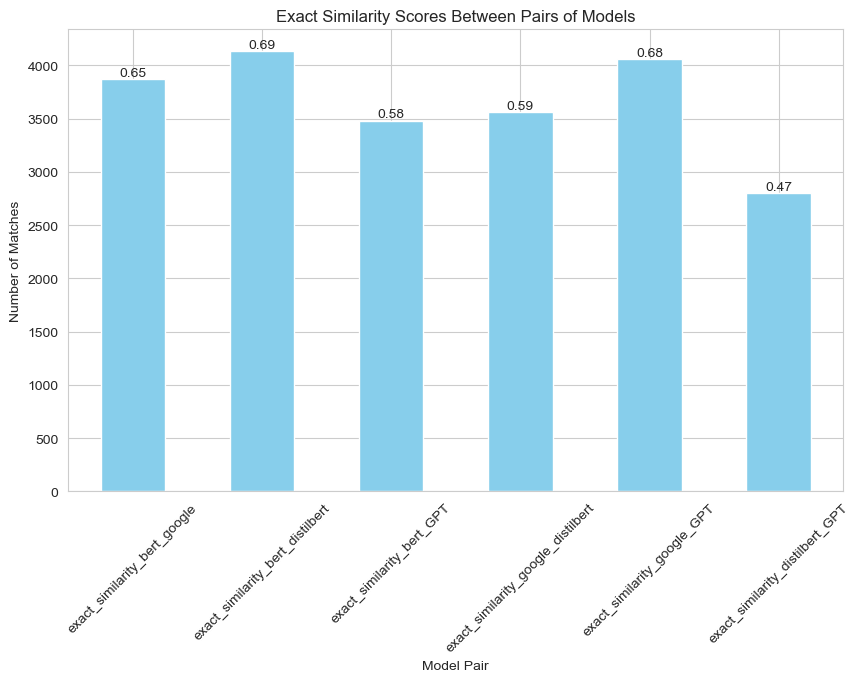

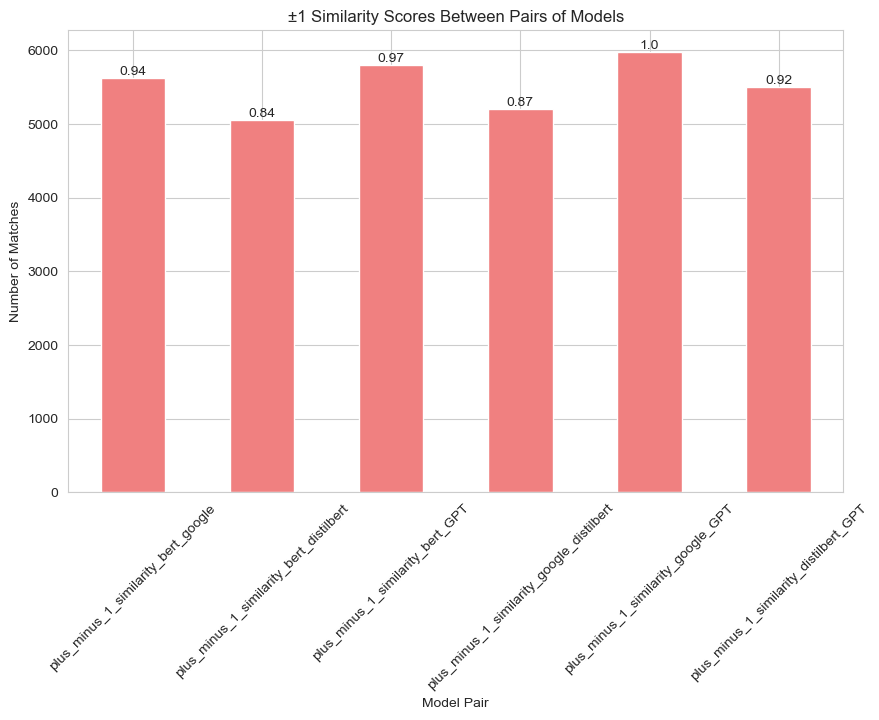

In [36]:
plt.figure(figsize=(10, 6))
ax1 = df[exact_similarity_columns].sum().plot(kind='bar', color='skyblue')
plt.title('Exact Similarity Scores Between Pairs of Models')
plt.ylabel('Number of Matches')
plt.xlabel('Model Pair')
plt.xticks(rotation=45)

for i, value in enumerate(df[exact_similarity_columns].sum()):
    ax1.text(i, value + 0.5, str(round(value/6000,2)), ha='center', va='bottom')

plt.show()

plt.figure(figsize=(10, 6))
ax2 = df[plus_minus_1_similarity_columns].sum().plot(kind='bar', color='lightcoral')
plt.title('±1 Similarity Scores Between Pairs of Models')
plt.ylabel('Number of Matches')
plt.xlabel('Model Pair')
plt.xticks(rotation=45)

for i, value in enumerate(df[plus_minus_1_similarity_columns].sum()):
    ax2.text(i, value + 0.5, str(round(value/6000,2)), ha='center', va='bottom')

plt.show()


First, looking at the bar plots, the BERT and Distlilbert, the Google Cloud NLP and GPT-4o mini models, as well as the BERT anf Google Cloud NLP models show the highest similarity for exact sentiment, exceeding 65%.

Additionally, the Google Cloud NLP and GPT-4o mini models have nearly 100% similarity when considering a margin, followed closely by the BERT-based model and GPT-4o mini, and then by the DistilBERT model and GPT-4o mini.

Given that GPT-4o mini, the BERT model and Google Cloud NLP are very similar in the second graph, that GPT-4o mini is falling behind in the exact sentiment comparison and the DistilBERT model is behind the other models in both comparisons, we should use either Google Cloud NLP or the BERT-based model. Even though Google Cloud NLP has a slightly better similarity in both comparisons, it also an expensive api for large datasets. We will therefore use the BERT-based model for the final sentiment analysis.

### Part 2.3.2: Semantic Similarity Analysis

The next step is to identify relevant themes in the comments, such as flavor, color, and others. This, combined with sentiment analysis and an LDA model, will help us better understand why certain characteristics might be controversial.

To achieve this, we will first use an embedding model such as [model name], on both the reviews and the themes, and apply cosine similarity (see function below) to determine which comments are "close" to each theme.

In [ ]:
def cosine_similarity(vec_a, vec_b):
    """
    Calculate the cosine similarity between two vectors.

    :param vec_a: Review vector.
    :param vec_b: Theme vector.
    :return: Cosine similarity.
    """
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

Finally, we will use an LDA model to generate topics that may be relevant to each theme.


The next steps are as follows :
* Assess and demonstrate the reliability of the selected embedding model.
* Evaluate and demonstrate the reliability of the chosen LDA model.
* For the controversial beers/themes, identify the most recurring topics in the reviews.
* If performance is lacking, we could consider using a summarizer as an alternative to LDA.

## Part 2.4 Which beer is controversial then ?

### Part 2.4.1 Labelling

### Part 2.4.2 Statistical testing and validation

# Part 3 Some reasons of controversiality

This part uses the label attributed to the beers. It tries to find patterns and reasons of controversial opinion as a function of "constant" variables such as abv and style of the beer, location of the brewery and the users, level of expertise of the users...

## Part 3.1 Novice/Enthusiasts/Connoisseur analysis

In this part, we classify the users related to how many ratings they did.

- Novice are users with only a few ratings : 1-20.
- Enthusiasts are users with moderate number of ratings : 21-100
- Connoisseur are users with high nuber of ratings . 101+

It is important to note that this choice has been arbitrarily made. It could be made differently or could be interactive for the reader of the story, enabling him to label users differently according to how many ratings he thinks is enough to be a connoisseur/enthusiasts/novice.

Another essential thing to take into account is that these classes do not represent users as novice or connoisseur about **beers**, but about **rating** on these particular website.

First step is to classify the users in the three mentioned categories.

In [ ]:
user_df = classify_user_rating_level(user_df, enthusiasts_level=21, connoisseur_level=101)
plot_category_distrib(user_df, 'rating_user_level')

## Part 3.2 Style of the beer and abv

## Part 3.2 Patterns in location and ratings of local or foreign beers

In [ ]:
# Under construction